In [86]:
import pickle
from functools import partial

import haiku as hk
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpy as np
import numpyro.distributions as dist
import optax
import tensorflow as tf
import tensorflow_probability as tfp
from tqdm import tqdm
from sbi_lens.config import config_lsst_y_10

tfp = tfp.experimental.substrates.jax
tfb = tfp.bijectors
tfd = tfp.distributions

In [111]:
total_steps = 500_000
sbi_method = 'nle'
batch_size = 256
params_name = config_lsst_y_10.params_name_latex

In [139]:
if sbi_method == "npe":
    dataset = np.load(
            "gpfswork/rech/eqw/ufa23yn/ssnpe_desc_project/data/LOADED&COMPRESSED_year_10_with_noise_score_density.npz",
            allow_pickle=True,
        )["arr_0"]

elif sbi_method == "nle":
    dataset = np.load(
            "/gpfswork/rech/eqw/ufa23yn/ssnpe_desc_project/data/LOADED&COMPRESSED_year_10_with_noise_score_conditional.npz",
            allow_pickle=True,
        )["arr_0"]


inds = jnp.unique(jnp.where(jnp.isnan(dataset.item()["score"]))[0])
dataset_score = jnp.delete(dataset.item()["score"], inds, axis=0)

dataset_train = dataset_score[:len(dataset_score) // 2]
dataset_test = dataset_score[len(dataset_score) // 2:]

In [113]:
class MomentNetwork(hk.Module):
 
  def __call__(self, score):
        
    net = hk.Linear(128)(score)
    net = jax.nn.relu(net)
    net = hk.Linear(128)(net)
    net = jax.nn.relu(net)
    net = hk.Linear(128)(net)
    net = jax.nn.relu(net)
    net = hk.Linear(128)(net)
    net = jax.nn.relu(net)
    net = hk.Linear(6)(net)

    return net.squeeze()

In [114]:
get_moments = hk.without_apply_rng(hk.transform(lambda p : MomentNetwork()(p)))

# Predict esperance

In [115]:
@jax.jit
def loss_esperance(params, score):

  out = get_moments.apply(params, score)

  return jnp.sum((out - score) ** 2, axis=-1).mean() 

@jax.jit
def update_esperance(params, opt_state, score):
    """Single SGD update step."""
    loss, grads = jax.value_and_grad(loss_esperance)(
        params, score
    )
    updates, new_opt_state = optimizer.update(grads, opt_state, params)
    new_params = optax.apply_updates(params, updates)

    return loss, new_params, new_opt_state

In [116]:
rng_seq = hk.PRNGSequence(12)
params_esperance = get_moments.init(next(rng_seq), jnp.zeros([1, 6]))

nb_steps = total_steps - total_steps * 0.2

lr_scheduler = optax.exponential_decay(
        init_value=0.001,
        transition_steps=nb_steps // 50,
        decay_rate=0.9,
        end_value=1e-5,
    )

optimizer = optax.adam(lr_scheduler)
opt_state_esperance = optimizer.init(params_esperance)

batch_loss = []
val_loss = []
lr_scheduler_store = []
pbar = tqdm(range(total_steps + 1))

for batch in pbar:
    inds = np.random.randint(0, len(dataset_train), batch_size)
    ex_score = dataset_train[inds]

    l, params_esperance, opt_state_esperance = update_esperance(
        params_esperance, opt_state_esperance, ex_score
    )

    if batch % 500 == 0:
      batch_loss.append(l)
      val_loss.append(loss_esperance(params_esperance, dataset_test[inds]))
      lr_scheduler_store.append(lr_scheduler(batch))
      pbar.set_description(f"train loss {l:.3f}")

    if jnp.isnan(l):
        break

train loss 0.418: 100%|██████████| 500001/500001 [04:15<00:00, 1958.02it/s]  


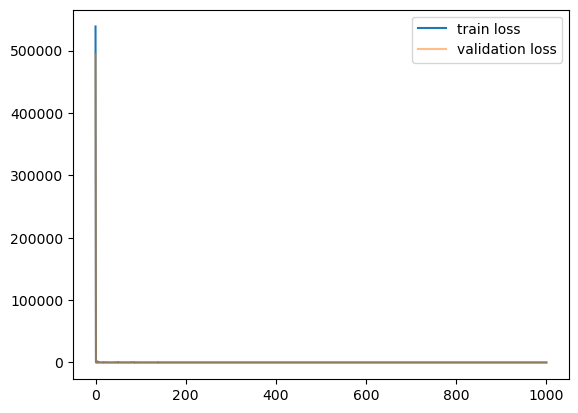

In [117]:
plt.plot(batch_loss, label = 'train loss')
plt.plot(val_loss, alpha = 0.5, label = 'validation loss')
plt.legend()
plt.savefig( "./SNR_study/loss.png")

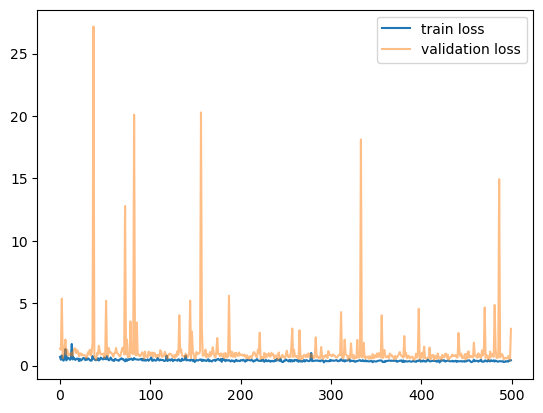

In [118]:
plt.plot(batch_loss[-500:], label = 'train loss')
plt.plot(val_loss[-500:], alpha = 0.5, label = 'validation loss')
plt.legend()
plt.savefig( "./SNR_study/loss_zoom.png")

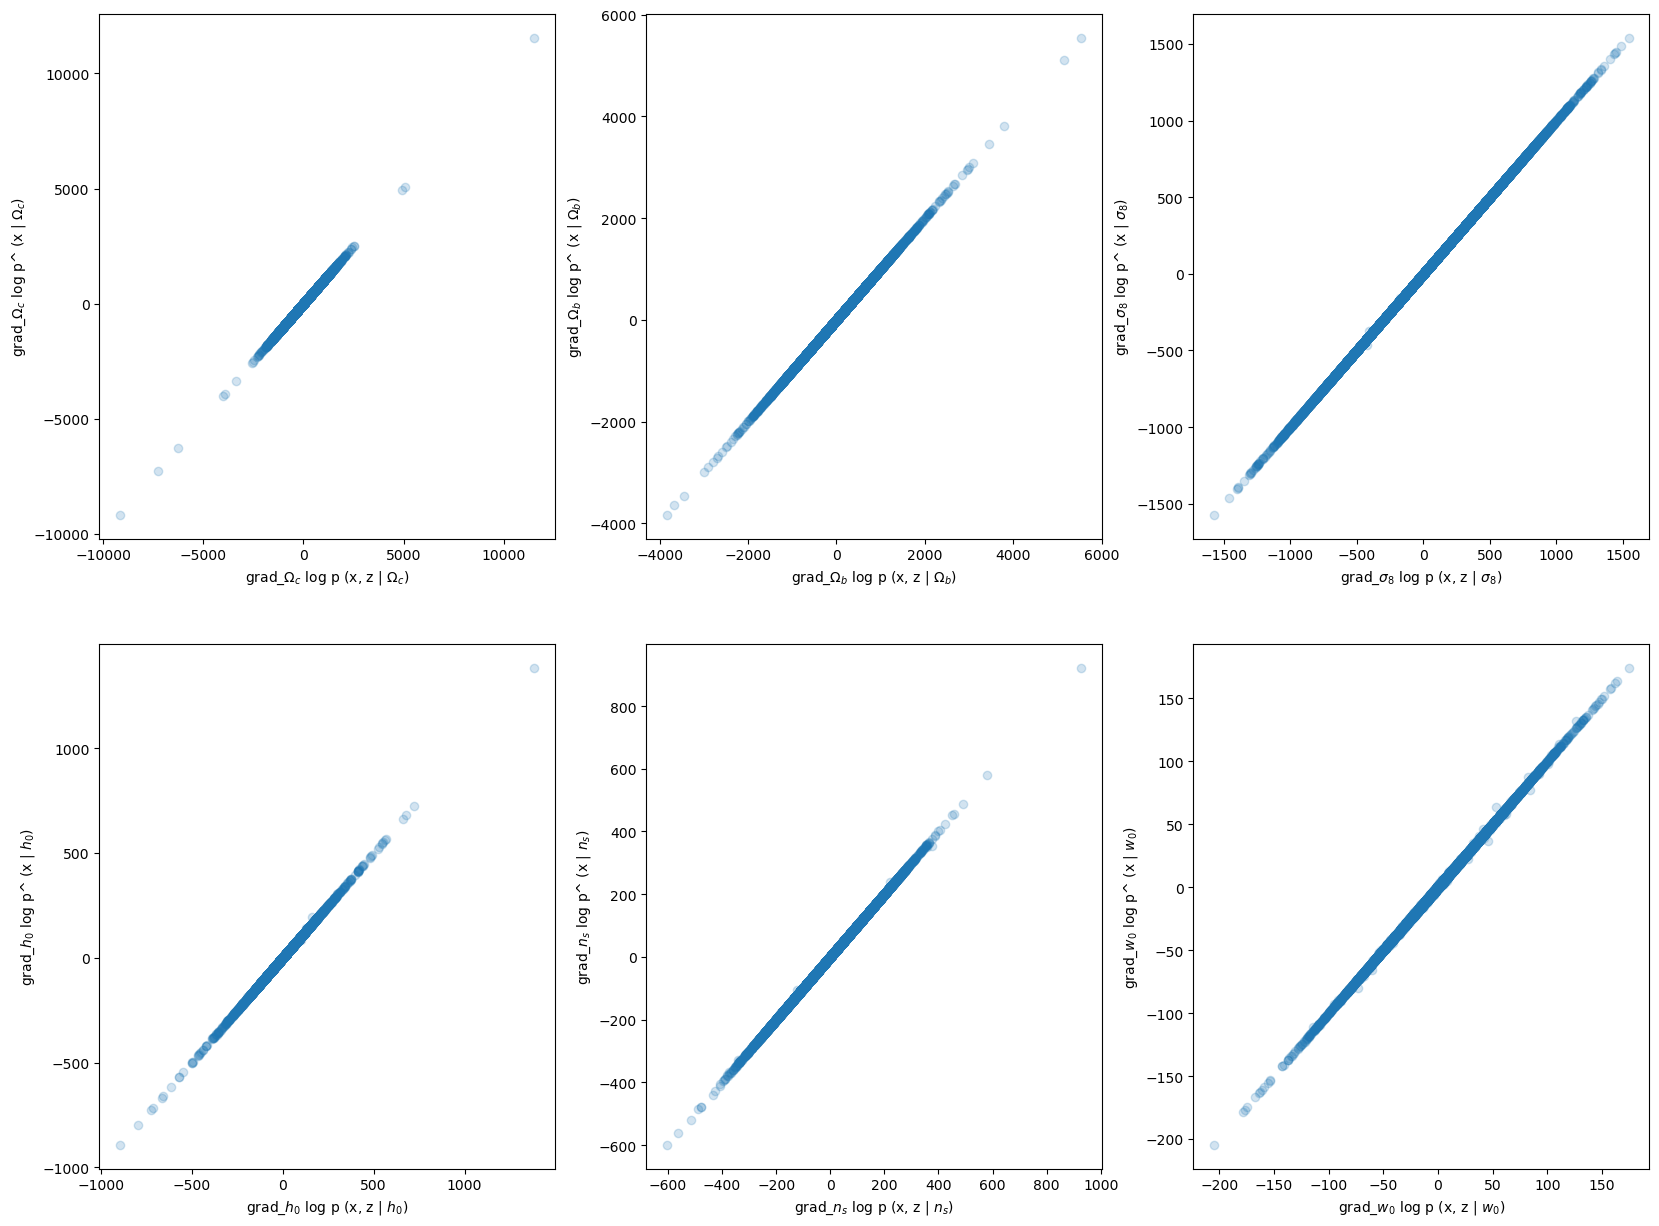

In [119]:
prediction = get_moments.apply(params_esperance,  dataset_test)

plt.figure(figsize=(20, 15))
for i in range(6):
  plt.subplot(2,3,i+1)
  plt.scatter(dataset_test[...,i], prediction[...,i], alpha = 0.2)
  plt.ylabel('grad_{} log p^ (x | {})'.format(params_name[i], params_name[i]))
  plt.xlabel('grad_{} log p (x, z | {})'.format(params_name[i], params_name[i]))
    
plt.savefig( "./SNR_study/regression.png")

In [120]:
with open(
   "./SNR_study/params_esp.pkl", "wb"
) as fp:
    pickle.dump(params_esperance, fp)

# Predict std

In [121]:
@jax.jit
def loss_std(params, score):

    approx_esp = get_moments.apply(params_esperance, score)
    approx_std = get_moments.apply(params, score)
    approx_var = approx_std ** 2
    var = (approx_esp - score) ** 2

    return jnp.sum((var - approx_var) ** 2, axis=-1).mean() 


@jax.jit
def update_std(params, opt_state, score):
    """Single SGD update step."""
    loss, grads = jax.value_and_grad(loss_std)(
        params, score
    )
    updates, new_opt_state = optimizer.update(grads, opt_state, params)
    new_params = optax.apply_updates(params, updates)

    return loss, new_params, new_opt_state

In [122]:
rng_seq = hk.PRNGSequence(10)
params_std = get_moments.init(next(rng_seq), jnp.zeros([1, 6]))

nb_steps = total_steps  - total_steps * 0.2

lr_scheduler = optax.exponential_decay(
        init_value=0.001,
        transition_steps=nb_steps // 50,
        decay_rate=0.9,
        end_value=1e-5,
    )

optimizer = optax.adam(lr_scheduler)
opt_state_std = optimizer.init(params_std)

batch_loss_std = []
val_loss_std = []
lr_scheduler_store = []
pbar = tqdm(range(total_steps + 1))

for batch in pbar:
    inds = np.random.randint(0, len(dataset_test) - 1, batch_size)
    ex_score = dataset_test[inds]

    l, params_std, opt_state_std = update_std(
        params_std, opt_state_std, ex_score
    )

    if batch % 500 == 0:
      batch_loss_std.append(l)
      val_loss_std.append(loss_std(params_std, dataset_train[inds]))
      lr_scheduler_store.append(lr_scheduler(batch))
      pbar.set_description(f"train loss {l:.3f}")

    if jnp.isnan(l):
        break

train loss 1.379: 100%|██████████| 500001/500001 [05:02<00:00, 1655.51it/s]     


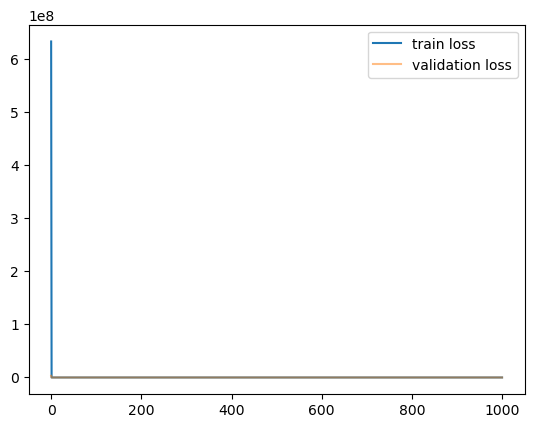

In [123]:
plt.plot(batch_loss_std, label = 'train loss')
plt.plot(val_loss_std, alpha = 0.5, label = 'validation loss')
plt.legend()
plt.savefig( "./SNR_study/loss_std.png")

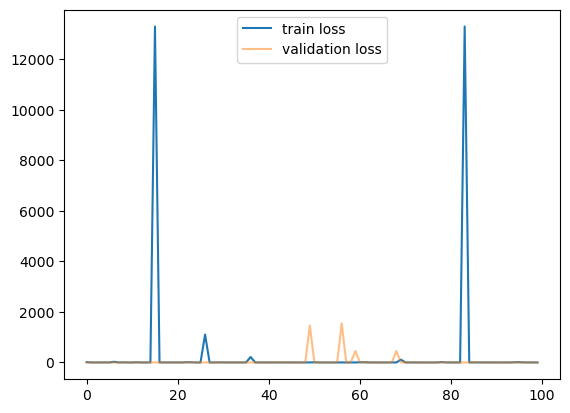

In [124]:
plt.plot(batch_loss_std[-100:], label = 'train loss')
plt.plot(val_loss_std[-100:], alpha = 0.5, label = 'validation loss')
plt.legend()
plt.savefig( "./SNR_study/loss_std_zoom.png")

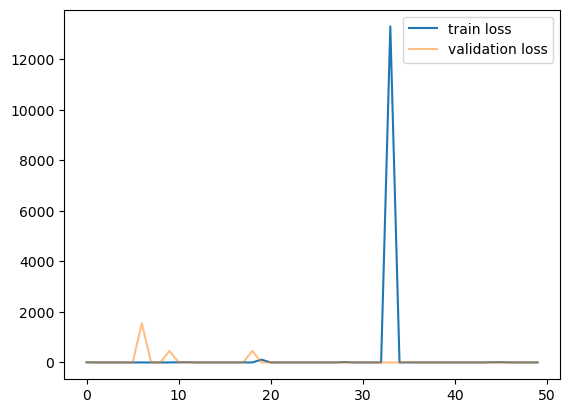

In [125]:
plt.plot(batch_loss_std[-50:], label = 'train loss')
plt.plot(val_loss_std[-50:], alpha = 0.5, label = 'validation loss')
plt.legend()
plt.savefig( "./SNR_study/loss_std_zoom.png")

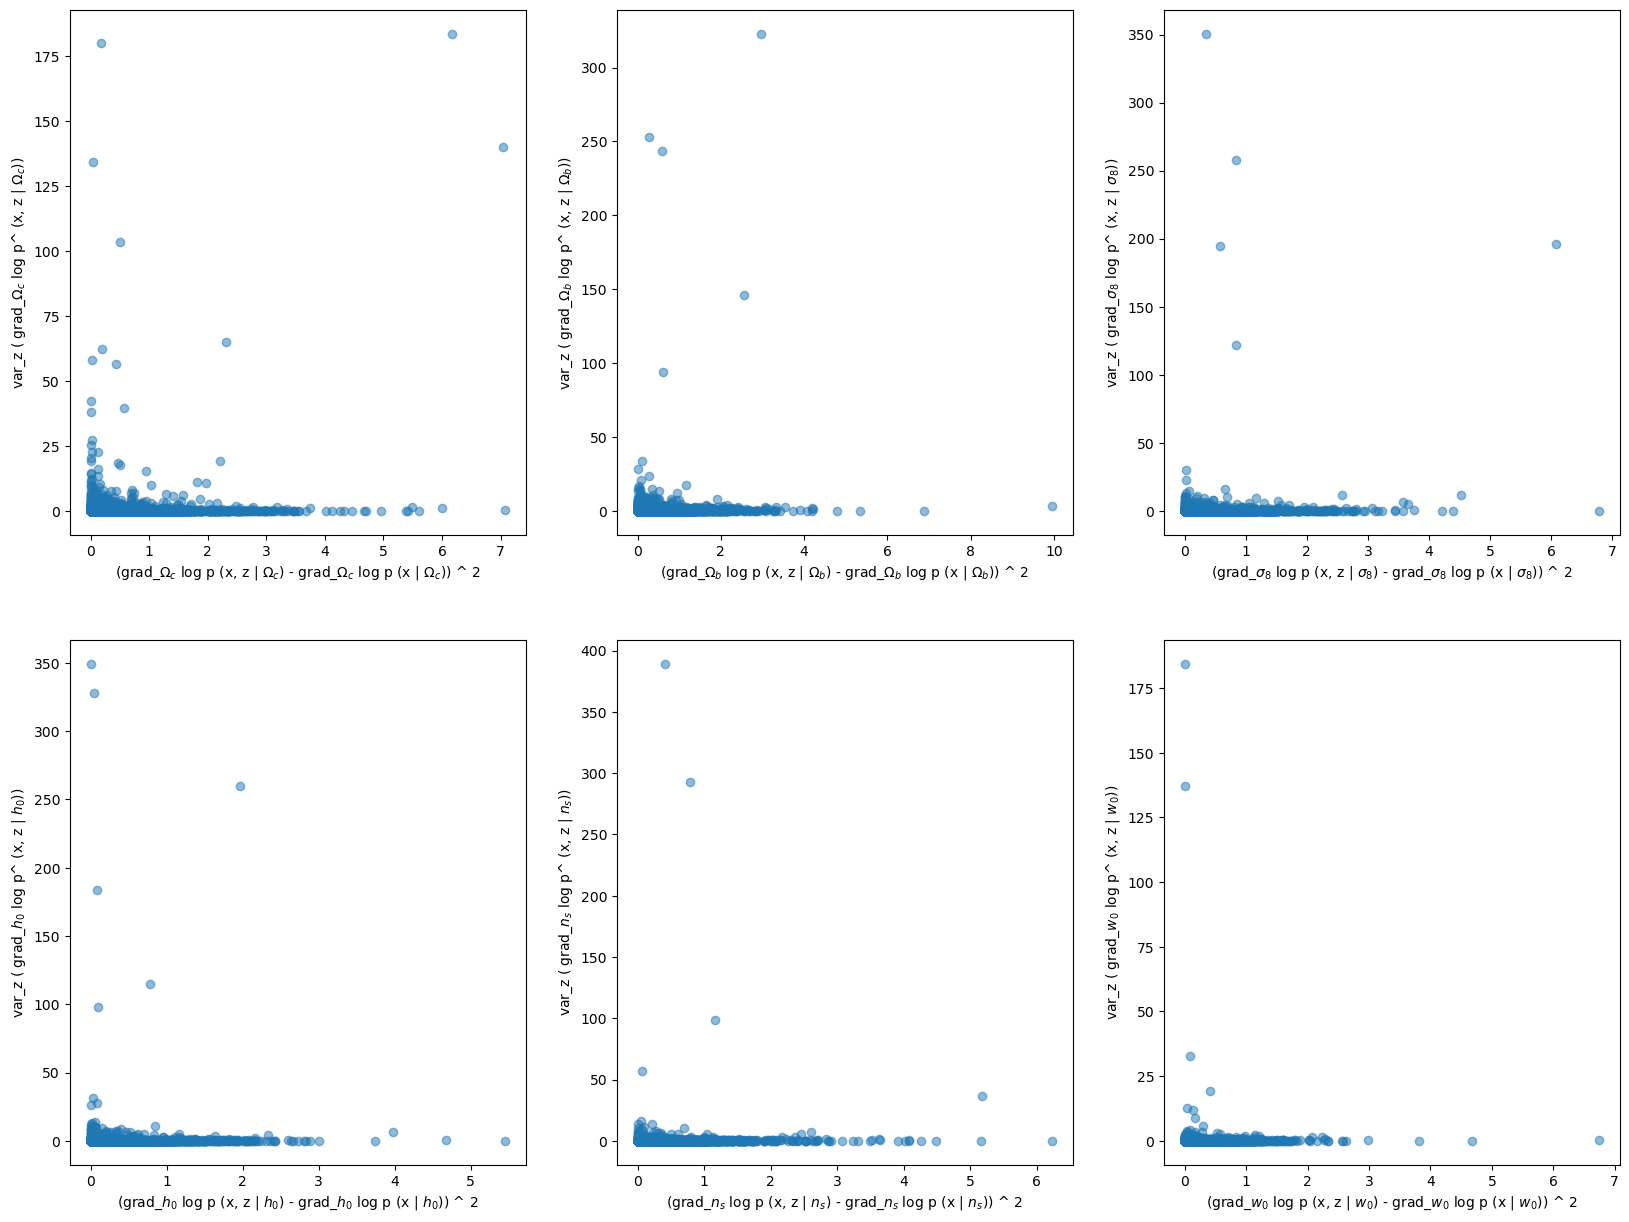

In [126]:
approx_esp = get_moments.apply(params_esperance, dataset_train)

var = (approx_esp - dataset_train) ** 2

approx_std = get_moments.apply(params_std, dataset_train)
prediction = approx_std ** 2

plt.figure(figsize=(20,15))
for i in range(6):
  plt.subplot(2,3,i+1)
  plt.scatter(var[...,i], prediction[...,i], alpha = 0.5)
  plt.ylabel('var_z ( grad_{} log p^ (x, z | {}))'.format(params_name[i], params_name[i]))
  plt.xlabel('(grad_{} log p (x, z | {}) - grad_{} log p (x | {})) ^ 2'.format(params_name[i], params_name[i], params_name[i], params_name[i]))

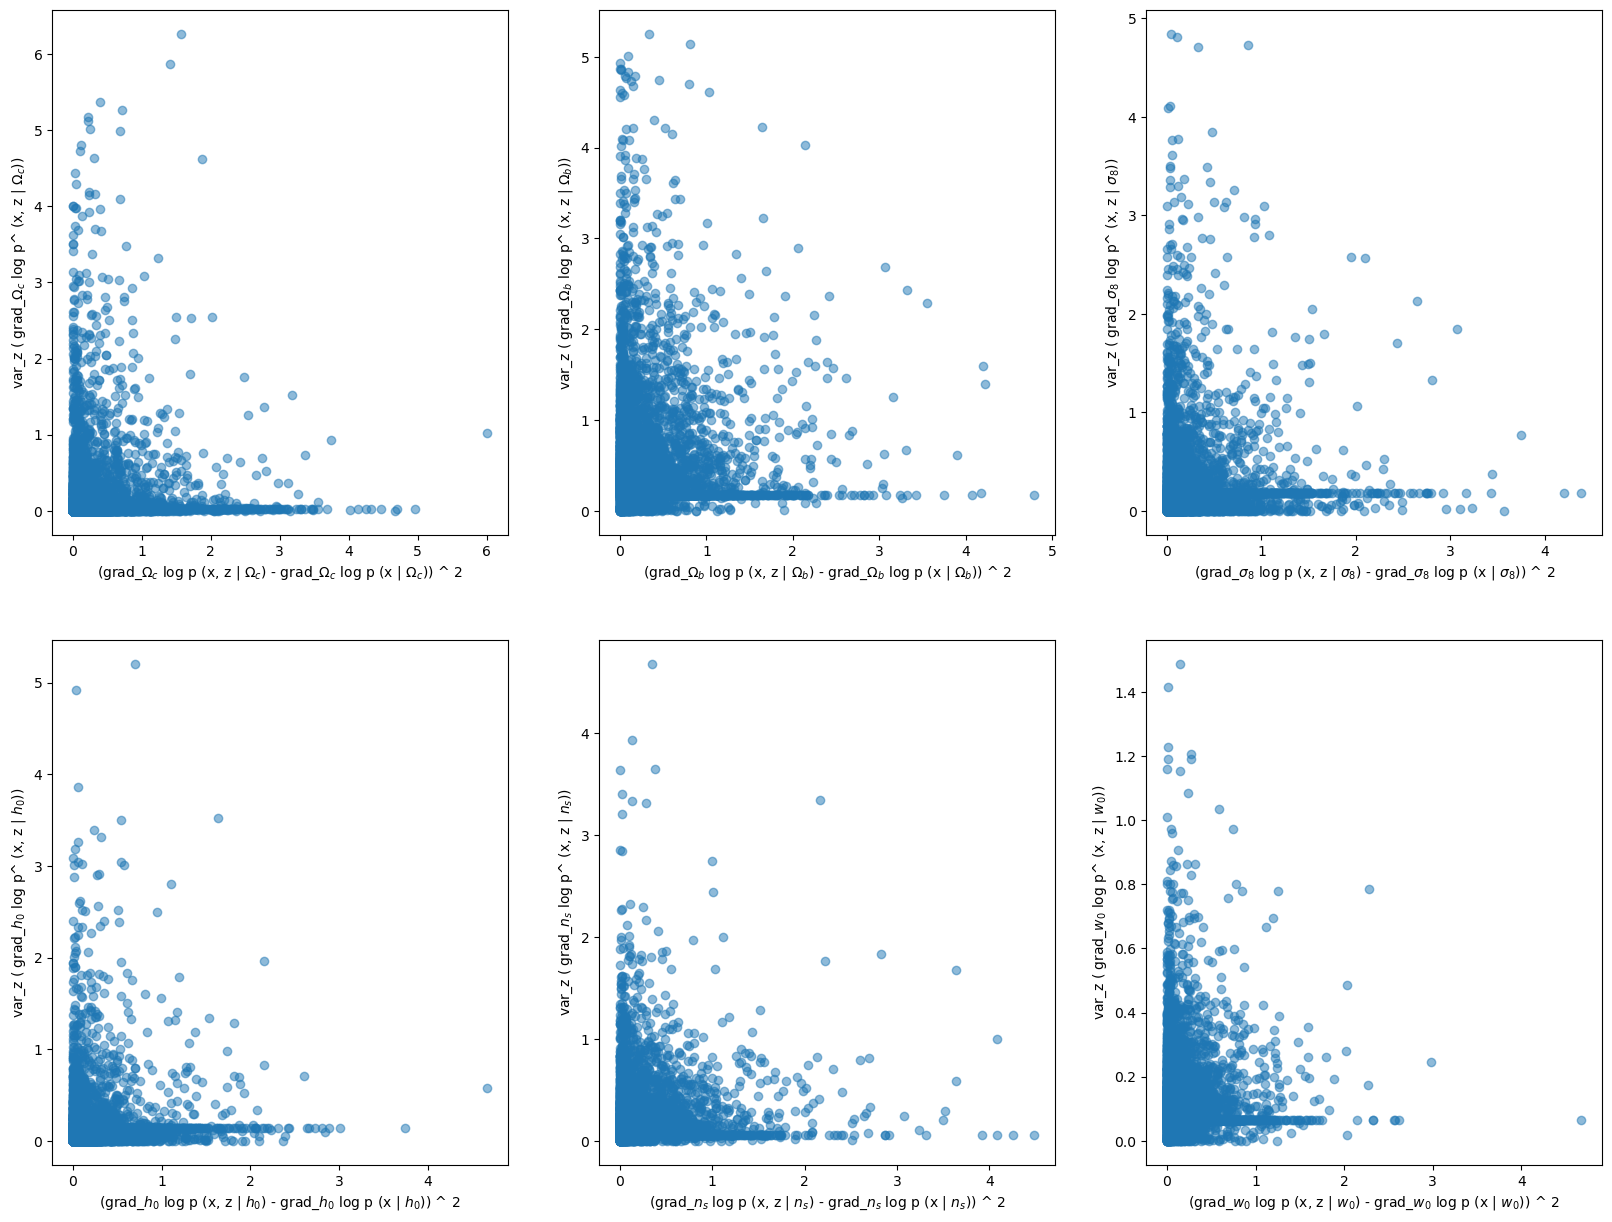

In [127]:
# remove outliers 

approx_esp = get_moments.apply(params_esperance, dataset_train)

var = (approx_esp - dataset_train) ** 2

approx_std = get_moments.apply(params_std, dataset_train)
prediction = approx_std ** 2

inds = jnp.unique(jnp.where(jnp.abs(prediction - var) > 5)[0])

var_2 = jnp.delete(var, inds, axis = 0)
pred_2 = jnp.delete(prediction, inds, axis = 0)
    
plt.figure(figsize=(20,15))
for i in range(6):
  plt.subplot(2,3,i+1)
  plt.scatter(var_2[...,i], pred_2[...,i], alpha = 0.5)
  plt.ylabel('var_z ( grad_{} log p^ (x, z | {}))'.format(params_name[i], params_name[i]))
  plt.xlabel('(grad_{} log p (x, z | {}) - grad_{} log p (x | {})) ^ 2'.format(params_name[i], params_name[i], params_name[i], params_name[i]))

# Compute SNR

In [128]:
def get_SNR(score):
  esperance = get_moments.apply(params_esperance, score)
  std = get_moments.apply(params_std, score)
  return esperance / std

In [129]:
get_SNR(dataset_score[-10:])

Array([[ -761.4297  ,  -865.09973 ,  -640.2625  ,   -74.94044 ,
          -94.74802 ,    38.56978 ],
       [   90.41808 ,  -468.50354 ,  -595.5808  ,  -106.79237 ,
         -147.37782 ,   -63.26035 ],
       [ 1726.0704  ,   480.7556  ,   410.67892 ,   -34.853245,
         -180.39159 ,   -75.33163 ],
       [ 1438.4725  ,   385.222   ,   255.49142 ,   179.66737 ,
          452.61874 ,   -27.178608],
       [ 5863.0703  ,  1497.1757  ,  1509.874   ,  -109.92305 ,
         -176.95709 ,   -55.19264 ],
       [ 2774.9011  ,   945.34296 ,   773.3762  ,    22.769297,
         -143.03777 ,    47.653362],
       [-2189.213   ,  -660.30426 ,  -513.2264  ,    33.860943,
          182.10739 ,    88.89888 ],
       [   35.250256,    49.80769 ,  3835.1675  ,  -509.59995 ,
          167.95332 ,    30.542124],
       [-8008.492   ,   259.71744 ,  -273.1926  ,   265.51    ,
          184.2477  ,    30.861145],
       [-4864.7104  , -1057.8795  , -1398.7219  ,   173.80551 ,
          416.79706 ,    66

In [130]:
esperance = get_moments.apply(params_esperance, dataset_score[-10:])
std = get_moments.apply(params_std, dataset_score[-10:])

In [131]:
esperance

Array([[-104.50873  , -356.7346   , -270.7852   ,   27.888083 ,
          23.222572 ,    9.773927 ],
       [  12.410179 , -193.19324  , -251.88803  ,   39.741356 ,
          36.122047 ,  -16.030739 ],
       [ 236.90884  ,  198.24553  ,  173.68777  ,   12.970169 ,
          44.21366  ,  -19.089708 ],
       [ 104.172714 ,  187.12485  ,   84.88777  ,  -51.13648  ,
        -131.67366  ,   -7.5936356],
       [ 804.7257   ,  617.3789   ,  638.5686   ,   40.906395 ,
          43.371872 ,  -13.986308 ],
       [ 380.8643   ,  389.82388  ,  327.08276  ,   -8.4732895,
          35.058304 ,   12.0757885],
       [-300.47665  , -272.28464  , -217.058    ,  -12.600897 ,
         -44.6342   ,   22.527771 ],
       [  -6.468002 ,   38.62385  ,  -98.37831  ,  -30.998264 ,
         -79.233444 ,   11.666384 ],
       [-118.84172  ,  143.08917  ,  -68.76908  ,  -54.931774 ,
         -61.097504 ,    9.334819 ],
       [-667.6975   , -436.22974  , -591.5592   ,  -64.6794   ,
        -102.15623  ,   16.

In [132]:
dataset_score[-10:]

array([[-105.36837  , -356.48538  , -270.69043  ,   27.896423 ,
          23.059677 ,    9.754538 ],
       [  12.406044 , -193.77557  , -251.45042  ,   39.748672 ,
          35.996895 ,  -16.011452 ],
       [ 236.87929  ,  198.29306  ,  173.6872   ,   12.964214 ,
          44.187244 ,  -19.082764 ],
       [ 104.77646  ,  186.93307  ,   84.69243  ,  -51.223267 ,
        -132.85619  ,   -6.556347 ],
       [ 804.6272   ,  617.5863   ,  638.5892   ,   40.877167 ,
          43.293144 ,  -13.995878 ],
       [ 380.7629   ,  389.95236  ,  327.12244  ,   -8.475769 ,
          35.047333 ,   12.185479 ],
       [-300.5276   , -272.22787  , -217.05838  ,  -12.6029625,
         -44.630943 ,   22.498167 ],
       [  -7.378427 ,   38.773643 ,  -97.64664  ,  -31.394073 ,
         -78.153725 ,   12.3643675],
       [-119.27785  ,  143.20071  ,  -68.34111  ,  -55.14219  ,
         -60.545082 ,    9.345825 ],
       [-667.78894  , -436.13794  , -591.5433   ,  -64.63228  ,
        -102.17309  ,   16.

In [133]:
std ** 2

Array([[1.88384634e-02, 1.70042753e-01, 1.78868428e-01, 1.38485685e-01,
        6.00731522e-02, 6.42160922e-02],
       [1.88384634e-02, 1.70042753e-01, 1.78868428e-01, 1.38485685e-01,
        6.00731522e-02, 6.42160922e-02],
       [1.88384634e-02, 1.70042753e-01, 1.78868428e-01, 1.38485685e-01,
        6.00731522e-02, 6.42160922e-02],
       [5.24450885e-03, 2.35961303e-01, 1.10392004e-01, 8.10071304e-02,
        8.46316293e-02, 7.80629739e-02],
       [1.88384634e-02, 1.70042753e-01, 1.78868428e-01, 1.38485685e-01,
        6.00731522e-02, 6.42160922e-02],
       [1.88384634e-02, 1.70042753e-01, 1.78868428e-01, 1.38485685e-01,
        6.00731522e-02, 6.42160922e-02],
       [1.88384634e-02, 1.70042753e-01, 1.78868428e-01, 1.38485685e-01,
        6.00731522e-02, 6.42160922e-02],
       [3.36678736e-02, 6.01337671e-01, 6.58006291e-04, 3.70012177e-03,
        2.22556293e-01, 1.45906314e-01],
       [2.20209666e-04, 3.03536773e-01, 6.33648708e-02, 4.28041145e-02,
        1.09962046e-01, 

In [134]:
std

Array([[ 0.13725328,  0.4123624 ,  0.4229284 , -0.37213665, -0.24509825,
         0.25340894],
       [ 0.13725328,  0.4123624 ,  0.4229284 , -0.37213665, -0.24509825,
         0.25340894],
       [ 0.13725328,  0.4123624 ,  0.4229284 , -0.37213665, -0.24509825,
         0.25340894],
       [ 0.07241898,  0.48575848,  0.33225292, -0.2846175 , -0.29091516,
         0.27939752],
       [ 0.13725328,  0.4123624 ,  0.4229284 , -0.37213665, -0.24509825,
         0.25340894],
       [ 0.13725328,  0.4123624 ,  0.4229284 , -0.37213665, -0.24509825,
         0.25340894],
       [ 0.13725328,  0.4123624 ,  0.4229284 , -0.37213665, -0.24509825,
         0.25340894],
       [-0.18348807,  0.77545965, -0.02565163,  0.06082863, -0.47175872,
         0.38197684],
       [ 0.01483946,  0.5509417 ,  0.2517238 , -0.20689155, -0.33160526,
         0.30247805],
       [ 0.13725328,  0.4123624 ,  0.4229284 , -0.37213665, -0.24509825,
         0.25340894]], dtype=float32)

# Create new dataset with learned marginal score

In [135]:
inds = jnp.unique(jnp.where(jnp.isnan(dataset.item()["score"]))[0])

dataset_y = jnp.delete(dataset.item()["y"], inds, axis=0)
dataset_score = jnp.delete(dataset.item()["score"], inds, axis=0)
dataset_theta = jnp.delete(dataset.item()["theta"], inds, axis=0)

learned_marginal_score = get_moments.apply(params_esperance, dataset_score)
    
dataset = {
    'theta': dataset_theta, 
    'score': learned_marginal_score, 
    'y': dataset_y, 
}

# saving the dataset
np.savez('LOADED&COMPRESSED_year_10_with_noise_score_conditional_marginal.npz', dataset)